### Testing
https://www.kaggle.com/code/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv

Receipt OCR Part 1: Image segmentation by OpenCV

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# from skimage.filters import threshold_local
from PIL import Image

In [41]:
def rescale(image_file):

    # get the height and weight of the image
    height, width = image_file.shape[:2]
    print(height) #testing
    print(width) # testing

    # calculate the aspect ratio
    aspect_ratio = width / height
    print(aspect_ratio) #testing

    # set new width and new height
    new_width = 600 
    new_height = round(aspect_ratio * new_width)
    
    # resize the image with new height
    resized_image = cv2.resize(image_file, (new_width, new_height))

    #return
    return resized_image


def grayscale(file_path:str):

    # Converting image to grayscale
    img_gray_mode = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Returning the new grayscale image
    return img_gray_mode

In [42]:
file_name = 'C:\workspace\SFUschool\cmpt310\cmpt310-rcpt-scan\data\dirty\large-receipt-image-dataset-SRD\\1000-receipt.jpg'

gray_image = grayscale(file_name)
scaled_image = rescale(gray_image)

1000
750
0.75


In [43]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

blurred = cv2.GaussianBlur(scaled_image, (5, 5), 0)
# plot_gray(blurred)



In [44]:
# Detect white regions

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
# plot_gray(dilated)

# Detect all contours in Canny-edged image
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(scaled_image.copy(), contours, -1, (0,255,0), 3)

# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(scaled_image.copy(), largest_contours, -1, (0,255,0), 3)

In [45]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
        

get_receipt_contour(largest_contours)


receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(scaled_image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
# plot_rgb(image_with_receipt_contour)

In [46]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / (500 / scaled_image.shape[0])

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

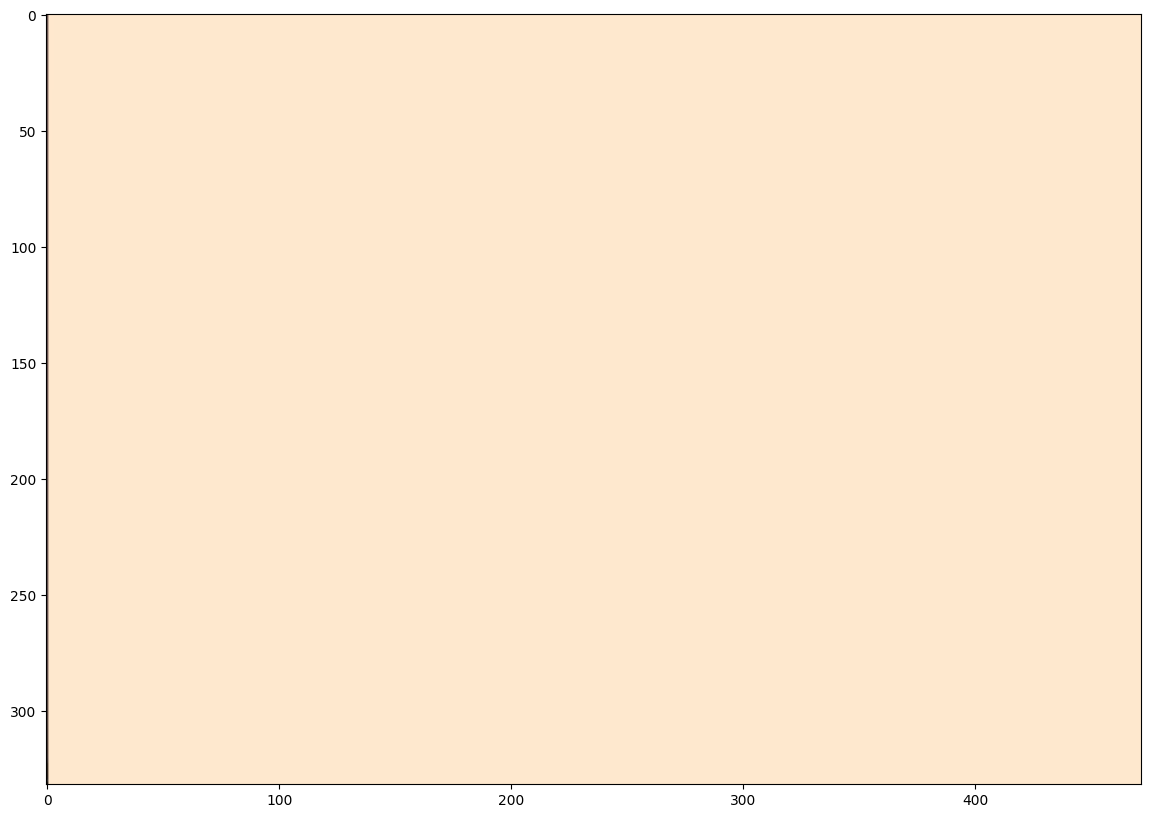

In [47]:
original = cv2.imread(file_name)
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)